In [1]:
import pandas as pd
import spacy
import networkx as nx                        # a really useful network analysis library
import matplotlib.pyplot as plt
# from networkx.algorithms import community   # not used, yet... 
import datetime                              # access to %%time, for timing individual notebook cells
import os

In [4]:
import en_core_web_lg
nlp = en_core_web_lg.load()           # A more detailed model (with higher-dimension word vectors) - 13s to load, normally 
#nlp = spacy.load('en_core_web_md')           # a smaller model, e.g. for testing

In [5]:
plt.rcParams['figure.figsize'] = [10, 10]  # makes the output plots large enough to be useful

In [8]:
rowlimit = 500              # this limits the tweets to a manageable number
data = pd.read_csv('../Datasets/ExtractedTweets.csv', nrows = rowlimit)
data.shape

(500, 3)

In [9]:
data.head(6)

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...
5,Democrat,RepDarrenSoto,RT @EmgageActionFL: Thank you to all who came ...


In [12]:
tokens = []
lemma = []
pos = []
parsed_doc = [] 
col_to_parse = 'Tweet'

for doc in nlp.pipe(data[col_to_parse].astype('unicode').values, batch_size=50):
    if doc.has_annotation("DEP"):
        parsed_doc.append(doc)
        tokens.append([n.text for n in doc])
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)


data['parsed_doc'] = parsed_doc
data['comment_tokens'] = tokens
data['comment_lemma'] = lemma
data['pos_pos'] = pos

In [13]:
data.head(8)

,Party,Handle,Tweet,parsed_doc,comment_tokens,comment_lemma,pos_pos
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...","(Today, ,, Senate, Dems, vote, to, #, SaveTheI...","[Today, ,, Senate, Dems, vote, to, #, SaveTheI...","[today, ,, Senate, Dems, vote, to, #, SaveTheI...","[NOUN, PUNCT, PROPN, PROPN, VERB, ADP, SYM, PR..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,"(RT, @WinterHavenSun, :, Winter, Haven, reside...","[RT, @WinterHavenSun, :, Winter, Haven, reside...","[RT, @WinterHavenSun, :, Winter, Haven, reside...","[PROPN, PROPN, PUNCT, PROPN, PROPN, NOUN, SYM,..."
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,"(RT, @NBCLatino, :, .@RepDarrenSoto, noted, th...","[RT, @NBCLatino, :, .@RepDarrenSoto, noted, th...","[RT, @NBCLatino, :, .@RepDarrenSoto, note, tha...","[PROPN, PROPN, PUNCT, PUNCT, VERB, SCONJ, PROP..."
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,"(RT, @NALCABPolicy, :, Meeting, with, @RepDarr...","[RT, @NALCABPolicy, :, Meeting, with, @RepDarr...","[RT, @nalcabpolicy, :, meeting, with, @RepDarr...","[PROPN, NOUN, PUNCT, NOUN, ADP, PROPN, PUNCT, ..."
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,"(RT, @Vegalteno, :, Hurricane, season, starts,...","[RT, @Vegalteno, :, Hurricane, season, starts,...","[RT, @Vegalteno, :, Hurricane, season, start, ...","[PROPN, PROPN, PUNCT, PROPN, NOUN, VERB, ADP, ..."
5,Democrat,RepDarrenSoto,RT @EmgageActionFL: Thank you to all who came ...,"(RT, @EmgageActionFL, :, Thank, you, to, all, ...","[RT, @EmgageActionFL, :, Thank, you, to, all, ...","[RT, @emgageactionfl, :, thank, you, to, all, ...","[PROPN, X, PUNCT, VERB, PRON, ADP, DET, PRON, ..."
6,Democrat,RepDarrenSoto,Hurricane Maria left approx $90 billion in dam...,"(Hurricane, Maria, left, approx, $, 90, billio...","[Hurricane, Maria, left, approx, $, 90, billio...","[Hurricane, Maria, leave, approx, $, 90, billi...","[PROPN, PROPN, VERB, NOUN, SYM, NUM, NUM, ADP,..."
7,Democrat,RepDarrenSoto,RT @Tharryry: I am delighted that @RepDarrenSo...,"(RT, @Tharryry, :, I, am, delighted, that, @Re...","[RT, @Tharryry, :, I, am, delighted, that, @Re...","[RT, @Tharryry, :, I, be, delighted, that, @Re...","[PROPN, PROPN, PUNCT, PRON, AUX, ADJ, SCONJ, P..."


In [14]:
data.Tweet[0]

'Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House… https://t.co/n3tggDLU1L'

In [15]:
data.Tweet[1]

'RT @WinterHavenSun: Winter Haven resident / Alta Vista teacher is one of several recognized by @RepDarrenSoto for National Teacher Apprecia…'

In [16]:
data.Tweet[10]

"RT @AllSaints_FL: Zhihan (John)'s art received awards at this year's state competitions. We just found out he's won the Congressional Distr…"

## Removing stopwords

We could reduce increase the signal:noise ratio in these texts by removing some of the more common words (or *stopwords*). By removing these from the tweets, we would prevent them from influencing the analysis of whether two tweets are similar. I'm not addressing this is the notebook yet, but I will come back to it later. For now, let's just look at what words are included in spaCy's stopword list.

In [17]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stopwords: %d' % len(stop_words))
print(list(stop_words))

Number of stopwords: 326
['made', "'d", '’re', 'myself', '‘ve', 'but', 'just', 'twenty', 'that', 'whereas', 'hereby', 'own', 'thereafter', 'top', 'nor', 'well', 'these', 'could', 'unless', 'yet', 'everything', 'back', 'front', 'behind', 'around', 'namely', 'least', 'does', 'anyway', 'someone', 'few', '‘re', '‘m', 'without', 'done', 'thereupon', 'therein', 'ours', 'n‘t', 'among', 'how', 'below', 'whither', 'any', 'becoming', 'towards', 'your', 'indeed', 'also', 'beside', 'both', 'them', 'therefore', 'so', 'per', 'whenever', 'twelve', 'something', 'forty', 'he', 'except', 'used', 'full', 'next', 'than', "'s", 'others', 'every', 'the', 'noone', 'upon', 'give', 'nobody', 'over', 'again', 'seems', 'between', 'itself', 'had', 'before', 'though', 'himself', 'thru', 'an', 'because', '‘ll', 'although', 'across', 'several', 'side', 'sixty', 'yours', 'whence', 'this', 'beforehand', 'first', 'fifty', 'former', 'up', 'are', 'seemed', 'whoever', 'nevertheless', 'who', 'here', 'anyhow', 'within', 'an

In [18]:
print(data['parsed_doc'][0].similarity(data['parsed_doc'][1]))
print(data['parsed_doc'][0].similarity(data['parsed_doc'][10]))
print(data['parsed_doc'][1].similarity(data['parsed_doc'][10]))

0.7445334012997202
0.850740458011101
0.8312295460861366


In [19]:
data.Party.unique()

array(['Democrat'], dtype=object)

In [20]:
world_data = data
#world_data = data[data.Party == 'Democrat']      # or use either of these, if you want to see tweets from only one party
#world_data = data[data.Party == 'Republican']

In [21]:
# takes 1s for 500 nodes - but of course this won't scale linearly!                              
raw_G = nx.Graph() # undirected
n = 0

for i in world_data['parsed_doc']:        # sure, it's inefficient, but it will do
    for j in world_data['parsed_doc']:
        if i != j:
            if not (raw_G.has_edge(j, i)):
                sim = i.similarity(j)
                raw_G.add_edge(i, j, weight = sim)
                n = n + 1

print(raw_G.number_of_nodes(), "nodes, and", raw_G.number_of_edges(), "edges created.")

<ipython-input-21-8e05153bac24>:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim = i.similarity(j)
500 nodes, and 124750 edges created.


In [22]:
edges_to_kill = []
min_wt = 0.94      # this is our cutoff value for a minimum edge-weight 

for n, nbrs in raw_G.adj.items():
    #print("\nProcessing origin-node:", n, "... ")
    for nbr, eattr in nbrs.items():
        # remove edges below a certain weight
        data = eattr['weight']
        if data < min_wt: 
            # print('(%.3f)' % (data))  
            # print('(%d, %d, %.3f)' % (n, nbr, data))  
            #print("\nNode: ", n, "\n <-", data, "-> ", "\nNeighbour: ", nbr)
            edges_to_kill.append((n, nbr)) 
            
print("\n", len(edges_to_kill) / 2, "edges to kill (of", raw_G.number_of_edges(), "), before de-duplicating")


 124680.0 edges to kill (of 124750 ), before de-duplicating


In [23]:
for u, v in edges_to_kill:
    if raw_G.has_edge(u, v):   # catches (e.g.) those edges where we've removed them using reverse ... (v, u)
        raw_G.remove_edge(u, v)

In [24]:
strong_G = raw_G
print(strong_G.number_of_edges())

70


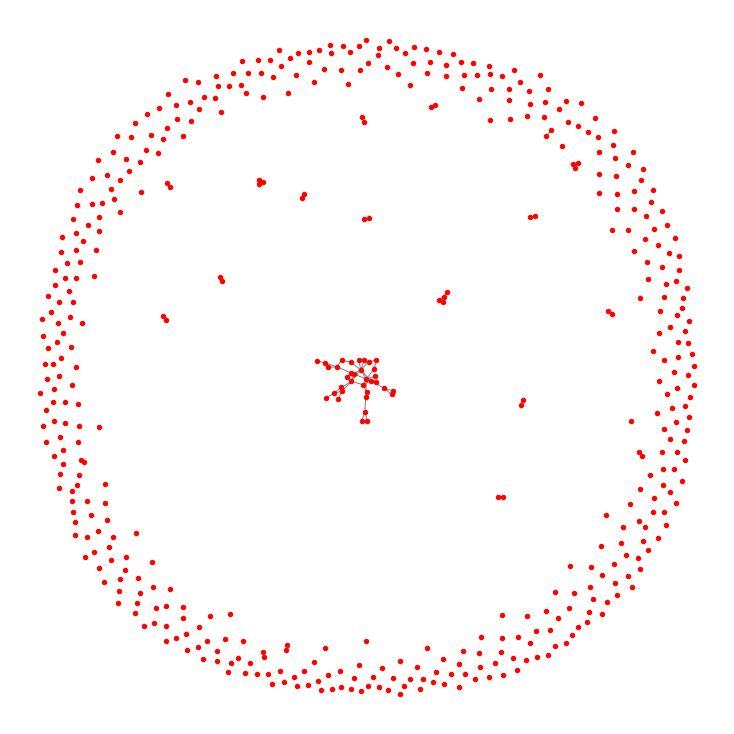

In [26]:
nx.draw(strong_G, node_size=20, edge_color='gray',node_color='red')

In [27]:
strong_G.remove_nodes_from(list(nx.isolates(strong_G)))

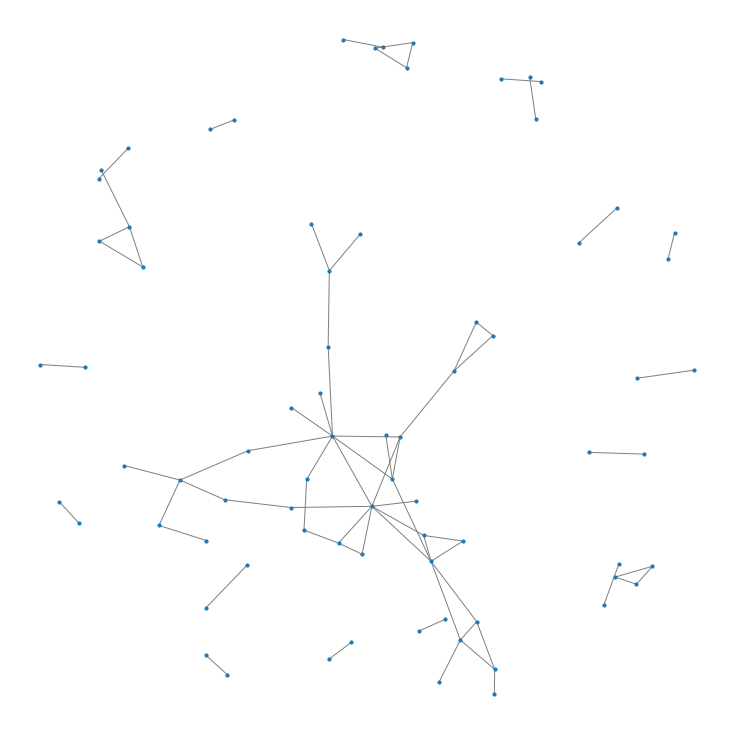

In [28]:
from math import sqrt
count = strong_G.number_of_nodes()
equilibrium = 10 / sqrt(count)    # default for this is 1/sqrt(n), but this will 'blow out' the layout for better visibility
pos = nx.fruchterman_reingold_layout(strong_G, k=equilibrium, iterations=300)
nx.draw(strong_G, pos=pos, node_size=10, edge_color='gray')

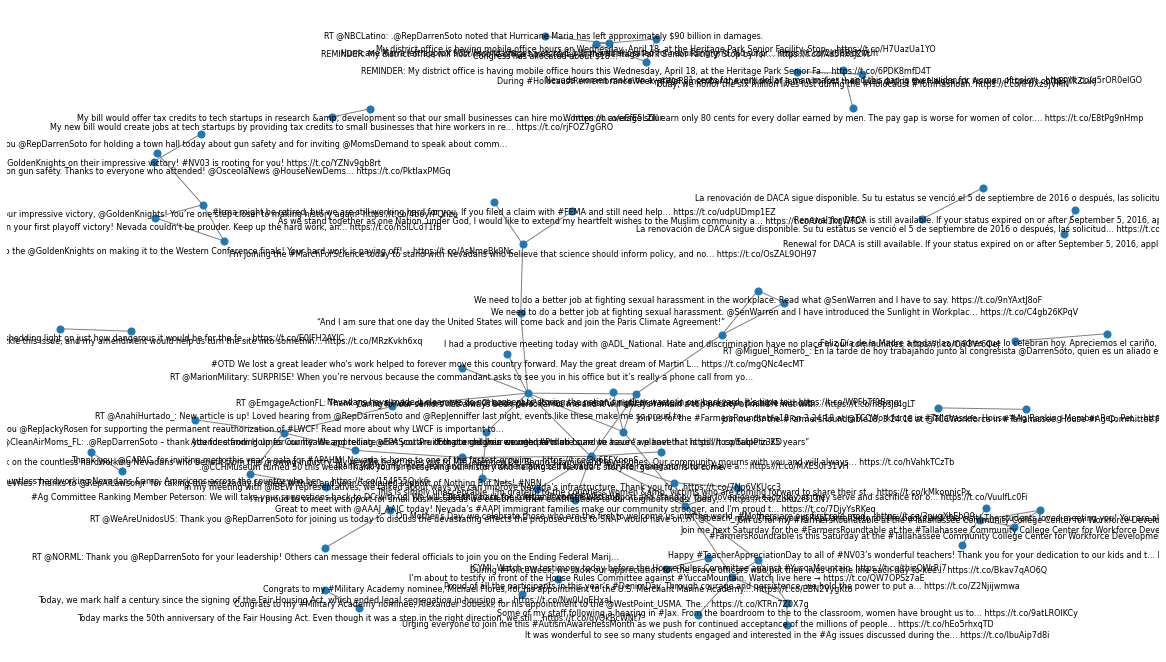

In [29]:
plt.rcParams['figure.figsize'] = [16, 9]  # a better aspect ratio for labelled nodes

nx.draw(strong_G, pos, font_size=3, node_size=50, edge_color='gray', with_labels=False)
for p in pos:  # raise positions of the labels, relative to the nodes
    pos[p][1] -= 0.03
nx.draw_networkx_labels(strong_G, pos, font_size=8, font_color='k')

plt.show()

I hope this notebook was useful. Next:
* I'd like to apply some keyword extraction to the tweets, to make this visualisation more useful;
* there'll be some topic identification using gensim's implementation of LDA;
* some more intelligent parameterisation of variables, such as allowing the minimum similarity cut-off to account for network size;
* I'd like to apply a smarter similarity cut-off, such as Vladimir Batagelj's '[vertex islands](http://vlado.fmf.uni-lj.si/pub/networks/doc/mix/islands.pdf)' technique; and
* I should really apply TF-IDF, if only just to see how it compares to other keyword extraction techniques.